# Report  4
### By Yada Pruksachatkun 

License: Attribution 4.0 International (CC BY 4.0)

Exercise 7.1. If buses arrive at a bus stop every 20 minutes, and you arrive at the bus stop at a random time, your wait time until the bus arrives is uniformly distributed from 0 to 20 minutes.


But in reality, there is variability in the time between buses. Suppose you are waiting for a bus, and you know the historical distribution of time between buses. Compute your distribution of wait times.


### Solution 

This is somewhat similar to the Boston Bruins problem. 
The number of times a bus comes in a 20-minute time span can be modelled using a Poisson distribution, and the number of minutes until the next bus arrives can be modelled by an Exponential distribution .

Suppose the historical data is the following: 1, 2, 1, 3, 1, 2 ,  the number of buses that arrived during previous 20-minute time spans. First, let us create teh class to model bus times. 

In [86]:
import math
from thinkbayes2 import Suite, EvalPoissonPmf, EvalExponentialPdf, MakeNormalPmf,  MakeExponentialPmf, MakePoissonPmf, EvalNormalPdf, Pmf, MakeMixture, Joint
import thinkplot
import numpy as np
from itertools import product

    

In [8]:
class Bus(Suite):
    """Represents hypotheses about the scoring rate for a team."""

    def __init__(self, label=None):
        """Initializes the Hockey object.

        label: string
        """
        mu = 2.8
        sigma = 0.3

        pmf = MakeNormalPmf(mu, sigma, num_sigmas=4, n=101)
        Suite.__init__(self, pmf, label="Bus")
            
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        Evaluates the Poisson PMF for lambda and k.

        hypo: goal scoring rate in goals per game
        data: goals scored in one game
        """
        lam = hypo
        k = data
        like = EvalPoissonPmf(k, lam)
        return like

In [9]:
suite1 = Bus()
suite1.UpdateSet([1, 2, 1, 3, 1, 2])

7.4240657475770666e-05

In [10]:
thinkplot.PrePlot(num=1)
thinkplot.Pdf(suite1)
thinkplot.Config(xlabel='Number of buses per 20-minute time period',
                ylabel='Probability')
suite1.Mean()

2.6092100785209746

THus, the mean value for lambda is 2.609 buses, meaning a bus comes every 7.69 minutes. However, given the probialgity of the various lambdas, we can weight the probaiblity of the wait time based on a mixture. 
We now need to model the probability, given lambda is 2.609, the probaiblity that the event will occur after k minutes, k being the number of minutes since minute 0 you arrive at the bus stop. 

In [11]:
                                                                                            
def MakeWaitPmf(suite, high=10):
    """Makes the distribution of goals scored, given distribution of lam.

    suite: distribution of goal-scoring rate
    high: upper bound

    returns: Pmf of goals per game
    """
    metapmf = Pmf()

    for lam, prob in suite.Items():
        pmf = MakePoissonPmf(lam, high=10)
        metapmf.Set(pmf, prob)

    mix = MakeMixture(metapmf, label=suite.label)
    return mix

2.6081500319561508

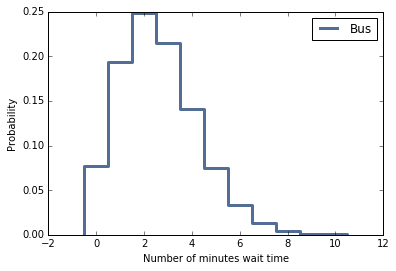

In [12]:
%matplotlib inline
import matplotlib.pyplot as plt
pmf = MakeWaitPmf(suite1)
thinkplot.PrePlot(num=2)
thinkplot.Pmf(pmf)
thinkplot.Config(xlabel='Number of minutes wait time',
                ylabel='Probability',
               )
pmf.Mean()


Thus, the number of minutes with the highest probaiblity is 2.6 minutes, with 25% chance. 

## Chapter 9 

Exercise 9.1. In our simple model, the opponent is equally likely to shoot in any
direction. As an exercise, let’s consider improvements to this model.
The analysis in this chapter suggests that a shooter is most likely to hit the closest wall. But in reality, if the opponent is close to a wall, he is unlikely to shoot at the wall because he is unlikely to see a target between himself and the wall.
Design an improved model that takes this behavior into account. Try to find a model that is more realistic, but not too complicated.

### My Solution 
My solution involves changing the MakeLocationPmf() method to include not only the Strafing speed but also how near the location is to the location of the shooter.

In [13]:
def get_distance(a, b):
    c_squared = (a**2) + (b**2) 
    c = math.sqrt(c_squared)
    return c

def MakeLocationPmf(alpha, beta, locations):
    """Computes the Pmf of the locations, given alpha and beta. 

    Given that the shooter is at coordinates (alpha, beta),
    the probability of hitting any spot is inversely proportionate
    to the strafe speed.

    alpha: x position
    beta: y position
    locations: x locations where the pmf is evaluated

    Returns: Pmf object
    """
    pmf = Pmf()
    for x in locations:
        prob = 1.0 / StrafingSpeed(alpha, beta, x)
        distance = get_distance(abs(alpha - x), beta)
        prob = prob * (distance*0.1)
        pmf.Set(x, prob)
    pmf.Normalize()
    return pmf

Running through the entire analysis again:

In [14]:
class Paintball(Suite, Joint):
    """Represents hypotheses about the location of an opponent."""

    def __init__(self, alphas, betas, locations):
        """Makes a joint suite of parameters alpha and beta.

        Enumerates all pairs of alpha and beta.
        Stores locations for use in Likelihood.

        alphas: possible values for alpha
        betas: possible values for beta
        locations: possible locations along the wall
        """
        self.locations = locations
        pairs = [(alpha, beta) 
                 for alpha in alphas 
                 for beta in betas]
        Suite.__init__(self, pairs)

    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.

        hypo: pair of alpha, beta
        data: location of a hit

        Returns: float likelihood
        """
        alpha, beta = hypo
        x = data
        pmf = MakeLocationPmf(alpha, beta, self.locations)
        like = pmf.Prob(x)
        return like

In [15]:

def StrafingSpeed(alpha, beta, x):
    """Computes strafing speed, given location of shooter and impact.

    alpha: x location of shooter
    beta: y location of shooter
    x: location of impact

    Returns: derivative of x with respect to theta
    """
    theta = math.atan2(x - alpha, beta)
    speed = beta / math.cos(theta)**2
    return speed

In [16]:
alphas = range(0, 31)
betas = range(1, 51)
locations = range(0, 31)

suite = Paintball(alphas, betas, locations)
suite.UpdateSet([15, 16, 18, 21])

1.441072655985378e-06

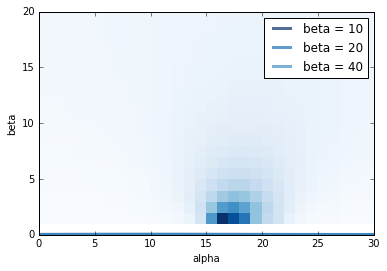

In [17]:
locations = range(0, 31)
alpha = 10
betas = [10, 20, 40]
thinkplot.PrePlot(num=len(betas))

for beta in betas:
    pmf = MakeLocationPmf(alpha, beta, locations)
    pmf.label = 'beta = %d' % beta
    thinkplot.Pdf(pmf)

thinkplot.Contour(suite.GetDict(), contour=False, pcolor=True)

thinkplot.Config(xlabel='alpha',
                ylabel='beta',
                axis=[0, 30, 0, 20])

Thus, according to the contour plot above, the shooter is motely in the coordinates (17, 10)

## Original Problems

## Type 1 
### Question: 
Alice recently got back an exam for her Machine Organization class, and saw that she got a question due to forgeting to label the unit for a question about converting from hexadecimal to binary she had forgot to write down base 2). She would like to talk to the grader who graded her exam. However, because the feedback is typed, she cannot tell which grader deducted her well-deserved point. Out of the other similarly small mistakes, of which there were 5, she only got points off for 3 of them.
She know, from past experience, that Grader 1 deducts points for similar mall types of errors 25% of the time, wherease Grader 2 deducts 75% of the time. 
Of course, Alice deducts that it is more probable thatn Grader 2 is the one grading, but by what probability cna she be so sure?

## Solution
The prior is 

In [18]:
class Grading(Suite):
    def __init__(self, hypos):
        Pmf.__init__(self)
        prob = [0.25,0.75]
        for hypo,prob in zip(hypos,prob):
            self.Set(hypo, prob)
        self.Normalize()
    
    def Likelihood(self, data, hypo):
            ''' 
            Data: is a boolean True meaning that she got a point deducted. 
                False meaning she did not get a point deducted. 
                Hypo: Grader 1 or Grader 2 
                '''
            if hypo == "Grader 1":
                if data == True:
                    return 0.25
                else:
                    return 0.75
            else:
                if data == True:
                    return 0.75
                else:
                    return 0.25
        

In [19]:
bball_suite = Grading(['Grader 1','Grader 2'])
bball_suite.UpdateSet([True, True, True, False, False])
bball_suite.Print()

Grader 1 0.1
Grader 2 0.9


Thus, the probability that Grader 2 graded her exam is almost 1, andt the probaiblty that Grader 2 is the grader is 0.8 more than that of Grader 1. Thus, Alice should talk to Grader 2.

## Type 3
### Problem : The Waiting Game

Lana Del Rey is currently running late to your workplace, which is at Menlo Park. Because Lana lives in San Francisco, there's two ways to get to your office; 1) Commuter railing there or 2) Ubering. Since Ubering costs 300% more than the first option, Lana would prefer the first option. 

For simplicity, let us assume that the commuter rail always takes 45 minutes.  

However, what Lana is worried about is waiting time. Because the commuter rail in SF is notoriously known to be slow or late, Lana's friends and her have created a record of how long Lana's waited for teh commuter rail. 

Lana has to be at work in 70 minutes. Should Lana take the first or second option?

You are given the number of minutes it has taken Lana's  friends in the past to wait for both.

Commuter rail: [0, 10, 5, 7, 3, 14, 13, 20, 60, 11]
Uber = :[1, 2, 1, 4, 3, 7, 10, 2, 5, 3]

## Solution 

We model both varaibles, x (waiting time for Uber) and y (waiting time for commuter rail) using exponential distribution, and represent the hypothesis with tuples of numbers. We want to find k and lambda for the exponential function to get the probability of the waiting time. 

In [73]:
# Solution


class TheWaitingGame(Suite, Joint):
    """Represents hypotheses about your location in the field."""

    def Likelihood(self, data, hypo):
        '''
        data: waiting time 
        hypo: mu, sigma
        '''
        mu, sigma = hypo
        return EvalNormalPdf(data, mu, sigma)

In [79]:
mu = np.linspace(1, 60) 
sigma = np.linspace(1, 10) 
# We assume that the average commute rail wait timeis going to be up to 1 hour (or else people would not use the 
# commuter rail and demand would plummet)
suite = TheWaitingGame((product(mu, sigma)))
suite.UpdateSet([0, 10, 5, 7, 3, 14, 13, 20, 11])

1.3228437438454481e-14

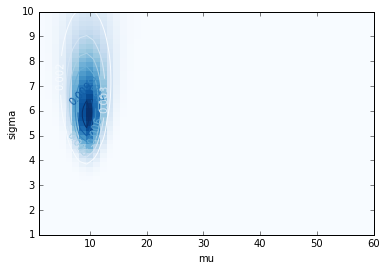

In [82]:
thinkplot.Contour(suite, pcolor=True)
thinkplot.Config(xlabel='mu', ylabel='sigma')

The above graph shows the distirubtion of simgas and mus based on our data. 
Now, let us try to find the mean mu 

In [102]:
pmf_mu = suite.Marginal(0)
mu = pmf_mu.Mean()
sum_res = 0
for k, v in pmf_mu.Items():
    if k < 25:
        sum_res = sum_res + v
print(sum_res)

0.999999922282


In [ ]:
In order for her to be late, the Commuter rail must be late by 25 minutes. However, after summing up the discrete probaiblities of late times, we can see that there is